In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
from itertools import chain, combinations

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, CategoricalNB
from sklearn.preprocessing import KBinsDiscretizer, LabelEncoder, StandardScaler
from sklearn.datasets import make_blobs, load_wine

from data_functions import load_data
from error_probs_model import ErrorProbsModel
from parzen_window_classifier import PWC

from functools import partial

from calibration import get_calibration_errors, get_ece, get_mce
from numpy.random import default_rng

import warnings
from plotting_functions import plot_decision_boundary

from matplotlib.lines import Line2D
from matplotlib.colors import ListedColormap
from matplotlib import cm
from ipywidgets import interact, IntSlider
rng = default_rng(12345)

In [2]:
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
def eval_classifier(classifier, X_test, y_test, results):
	
	y_pred = classifier.predict(X_test)
	results['accuracies'].append(np.round(np.sum(y_pred == y_test) / len(y_test), 3))

	results['mce'].append(np.round(get_mce(y_test, y_pred), 3))
	results['ece'].append(np.round(get_ece(y_test, y_pred), 3))
	
def select_fixed_annotator(**kwargs):

	n_instances = kwargs['X_selected'].shape[0]
	annotators = np.zeros(n_instances, dtype=int) + kwargs['annotator']

	return annotators

def select_random_annotator(**kwargs):

	n_annotators = kwargs['y_DL'].shape[1]
	n_instances = kwargs['X_selected'].shape[0]
	annotators = rng.choice(np.arange(n_annotators), n_instances)

	return annotators

def select_annotator_epm(**kwargs):
	
	X_train = kwargs['X_train']
	selected_idx = kwargs['X_selected']
	y_DL = kwargs['y_DL']
	epm = ErrorProbsModel(kwargs['n_classes'])
	epm.fit(X_train, y_DL)
	label_accuracy = epm.predict(X_train[selected_idx])

	# prevent same annotator from labeling again
	labels = y_DL[selected_idx]
	label_accuracy[~np.isnan(labels)] = 0.

	annotators = np.argmax(label_accuracy, axis=1)
	return annotators

def selection(n, classifier, query_strategy, annotator_selection, X_train, y_train, y_DL, relabel=True):

	n_classes = len(np.unique(y_train))

	mask = np.sum(~np.isnan(y_DL), axis=1) == 0
	if relabel:
		mask[:] = True
	instances_idx = query_strategy(n, classifier, X_train, y_DL, mask)
	annotators_idx = annotator_selection(X_train=X_train, X_selected=instances_idx, y_DL=y_DL,
									  	 n_classes=n_classes)
	
	y_DL[instances_idx, annotators_idx] = y_train[instances_idx, annotators_idx]

	return y_DL

def margin_qs(n, classifier, X, y, mask):

	p = classifier.predict_proba(X)
	instances_idx = np.argsort(np.diff(np.sort(p, axis=1))[:,-1])
	instances_idx = np.array([x for x in instances_idx if x not in np.arange(X.shape[0])[~mask]])
	instances_idx = instances_idx[:n]

	if len(instances_idx) != 10:
		print("hello")

	return instances_idx

def initial_choice(y_train, nbudget, n_annotators):

	y_DL = np.empty_like(y_train, dtype=float)
	y_DL[:] = np.nan
	
	# initial choice
	idx = [i for l in [rng.choice(np.where(y_train==c)[0],nbudget,replace=False)
						for c in np.unique(y_train)] for i in l]

	mask = np.zeros_like(y_train, dtype=bool)
	annotators = rng.integers(0, n_annotators, nbudget * len(np.unique(y_train)))

	mask[idx, annotators] = True
	y_DL[mask] = y_train[mask]
	
	return y_DL

def run_experiment(data_set_name, seed, classifier, nbudget=5, query_strategy=margin_qs, 
				   annnotator_selection=select_random_annotator, verbose=False, relabel=True,
				   n_iterations=None):
	
	X, y_true, y = load_data(data_set_name)

	n_classes = len(np.unique(y_true))
	n_instances, n_annotators = y.shape

	budget = nbudget * n_classes

	X_train, X_test, y_train_idx, y_test_idx = train_test_split(X, np.arange(len(y_true)), test_size=0.4, random_state=seed)

	y_train = y[y_train_idx]
	y_test = y_true[y_test_idx]

	y_DL = initial_choice(y_train, nbudget, n_annotators)
	
	# Standardize
	scaler = StandardScaler().fit(X_train)
	X_train = scaler.transform(X_train)
	X_test = scaler.transform(X_test)

	if isinstance(classifier, partial) and classifier.func == PWC:
		classifier = classifier(n_classes=n_classes)
	else:
		classifier = classifier()
	if not n_iterations:
		n_iterations = np.minimum(len(X_test) // (budget), 50)
	
	results = {'accuracies': [], 'mce': [], 'ece': [], 'api': [], 'classes' : n_classes,
			 'instances' : n_instances, 'annotators': n_annotators, 'max_annotations': [],
			 'n_annotations' : [np.zeros(240)], 'y_DL': [y_DL.copy()], 'X_train': X_train}

	# AL loop
	for i in range(n_iterations):

		classifier.fit(X_train, y_DL)
		
		eval_classifier(classifier, X_test, y_test, results)

		y_DL = selection(budget, classifier, query_strategy, annnotator_selection, 
				   		 X_train, y_train, y_DL, relabel=relabel)

		n_annotations = np.sum(~np.isnan(y_DL), axis=1)
		results['n_annotations'].append(n_annotations)
		results['max_annotations'].append(np.max(n_annotations))
		mask = n_annotations != 0
		results['api'].append(np.mean(n_annotations[mask]).round(2))
		results['y_DL'].append(y_DL.copy())

		if verbose:
			print(f'Iteration: {i}. Accuracy: {results['accuracies'][-1]}. MCE: {results['mce'][-1]}. ECE: {results['ece'][-1]}')
			print(f'Annotations per instance: {results['api'][-1]}. Max annotations: {results['max_annotations'][-1]}')
			print(np.sum(n_annotations))
	
	return results

data_set_name = 'blobs_n_2-simulated-o'
seed = 1234
relabel = True
annotator = 0
nbudget=5
#anntator_selection = partial(select_fixed_annotator, annotator=annotator)
annotator_selection = select_annotator_epm
query_strategy = margin_qs
classifier = partial(PWC, metric='rbf')
with warnings.catch_warnings():
	warnings.filterwarnings("ignore", category= RuntimeWarning)
	warnings.filterwarnings("ignore", category= FutureWarning)
	res = run_experiment(data_set_name=data_set_name, seed=seed, classifier=classifier, 
						nbudget=nbudget, query_strategy=query_strategy, annnotator_selection=annotator_selection, 
						verbose=True, relabel=relabel, n_iterations=100
						)


Iteration: 0. Accuracy: 0.644. MCE: 0.413. ECE: 0.356
Annotations per instance: 1.05. Max annotations: 2
20
Iteration: 1. Accuracy: 0.912. MCE: 0.14. ECE: 0.081
Annotations per instance: 1.03. Max annotations: 2
30
Iteration: 2. Accuracy: 0.894. MCE: 0.173. ECE: 0.106
Annotations per instance: 1.11. Max annotations: 2
40
Iteration: 3. Accuracy: 0.9. MCE: 0.143. ECE: 0.081
Annotations per instance: 1.16. Max annotations: 3
50
Iteration: 4. Accuracy: 0.881. MCE: 0.044. ECE: 0.019
Annotations per instance: 1.13. Max annotations: 3
60
Iteration: 5. Accuracy: 0.925. MCE: 0.063. ECE: 0.031
Annotations per instance: 1.13. Max annotations: 3
70
Iteration: 6. Accuracy: 0.925. MCE: 0.121. ECE: 0.069
Annotations per instance: 1.16. Max annotations: 3
80
Iteration: 7. Accuracy: 0.906. MCE: 0.098. ECE: 0.05
Annotations per instance: 1.2. Max annotations: 3
90
Iteration: 8. Accuracy: 0.85. MCE: 0.033. ECE: 0.013
Annotations per instance: 1.2. Max annotations: 3
100
Iteration: 9. Accuracy: 0.919. MCE

blobs_n_2-simulated-o


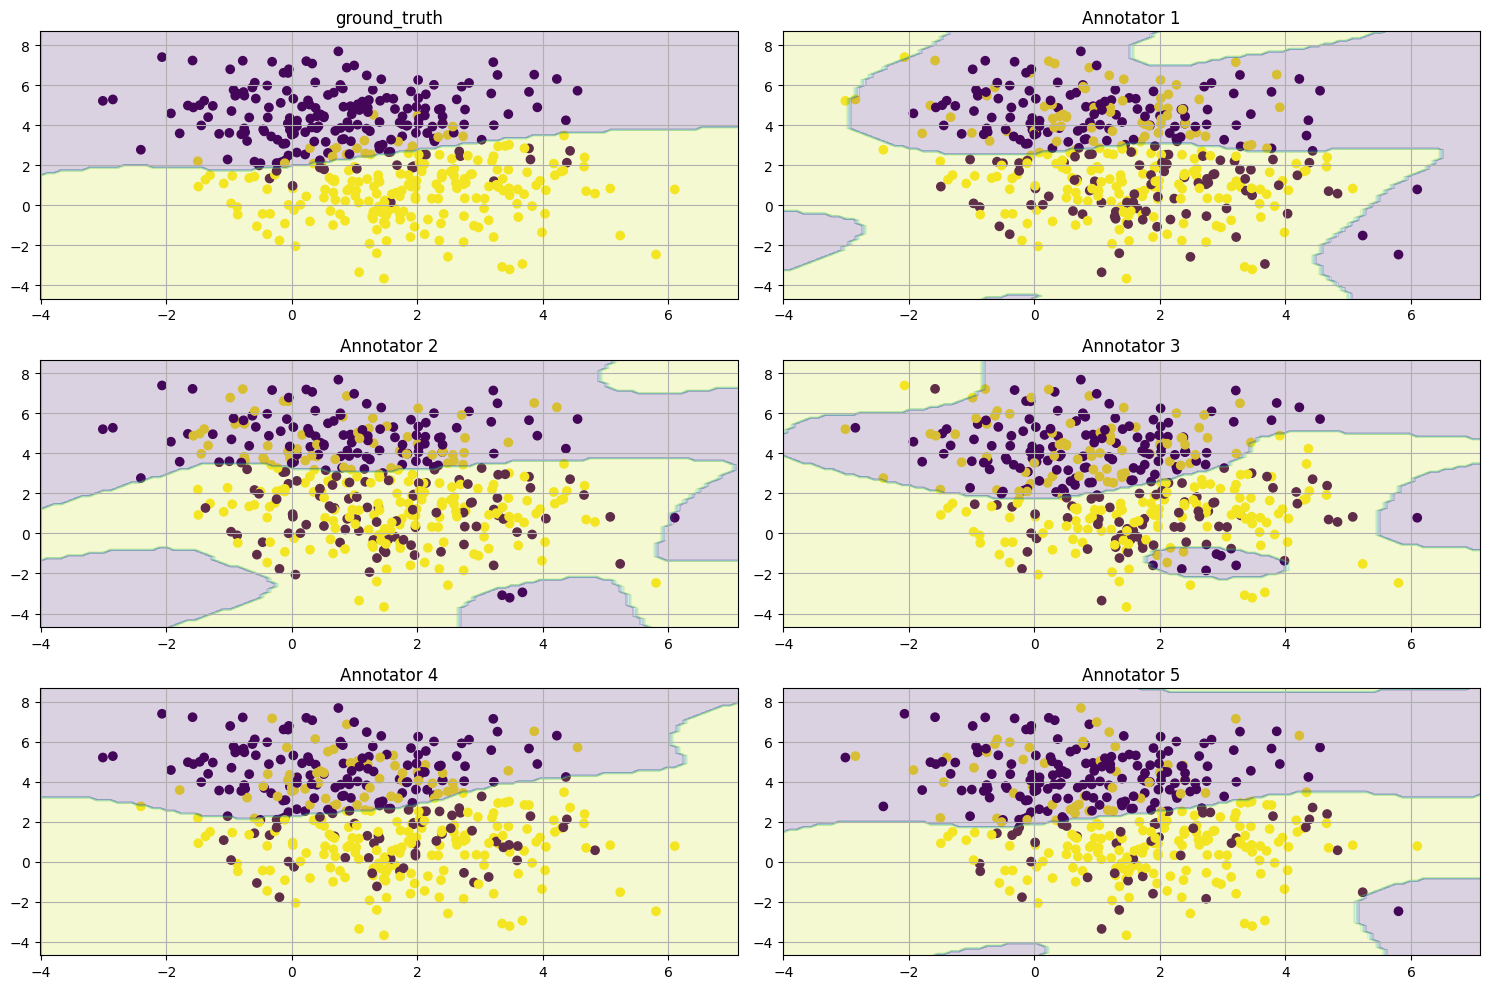

blobs_n_2-simulated-x


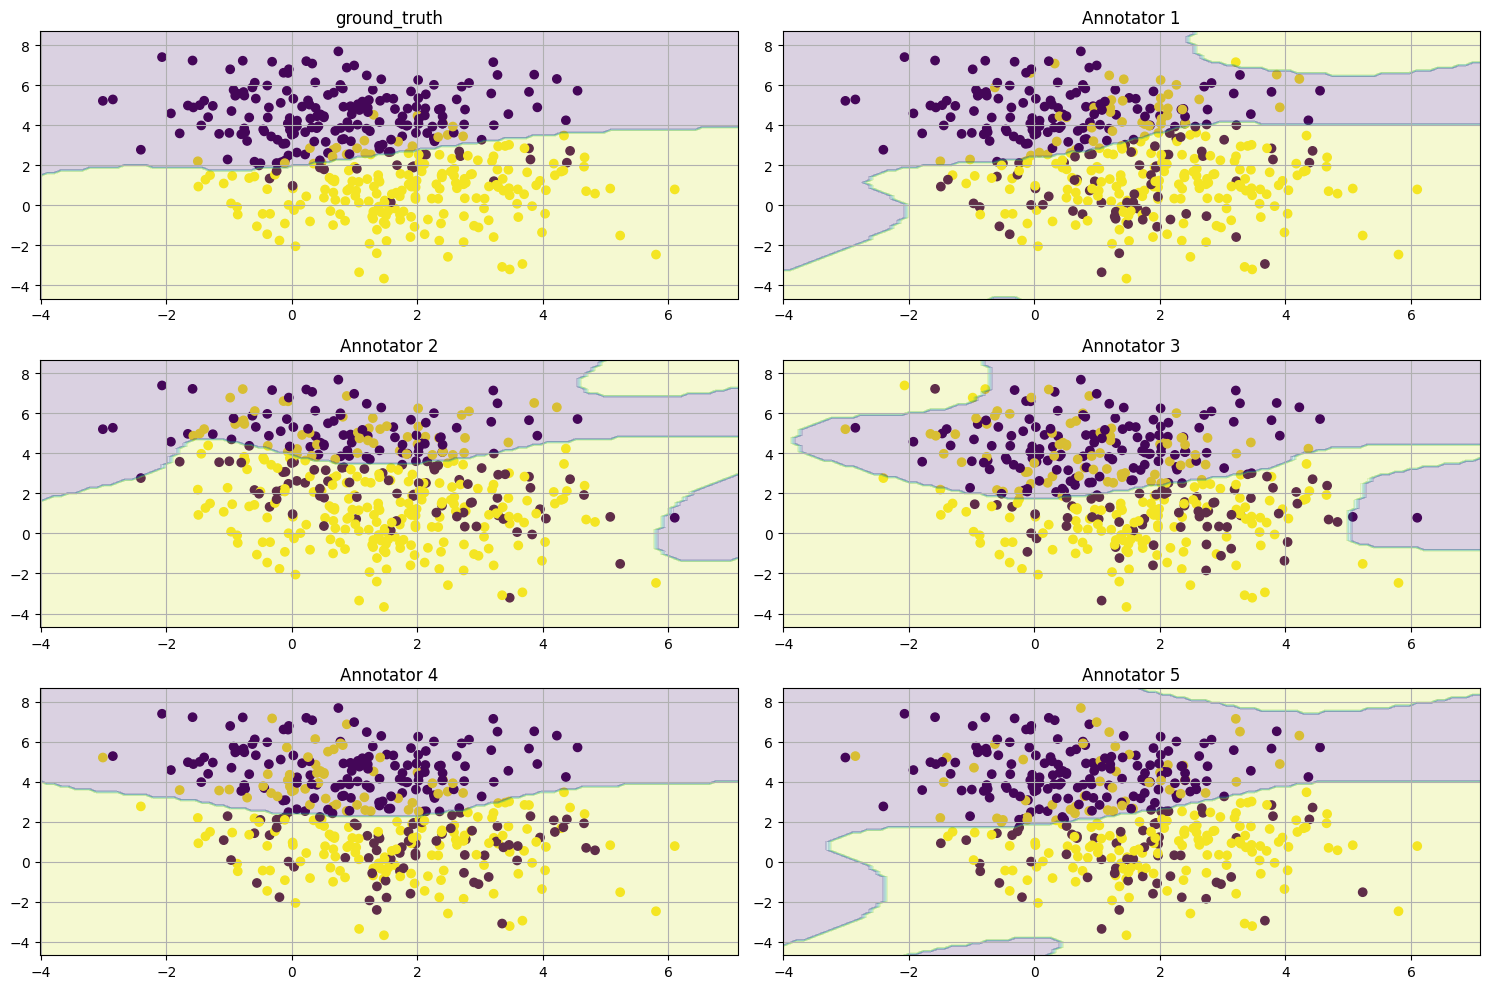

blobs_n_2-simulated-y


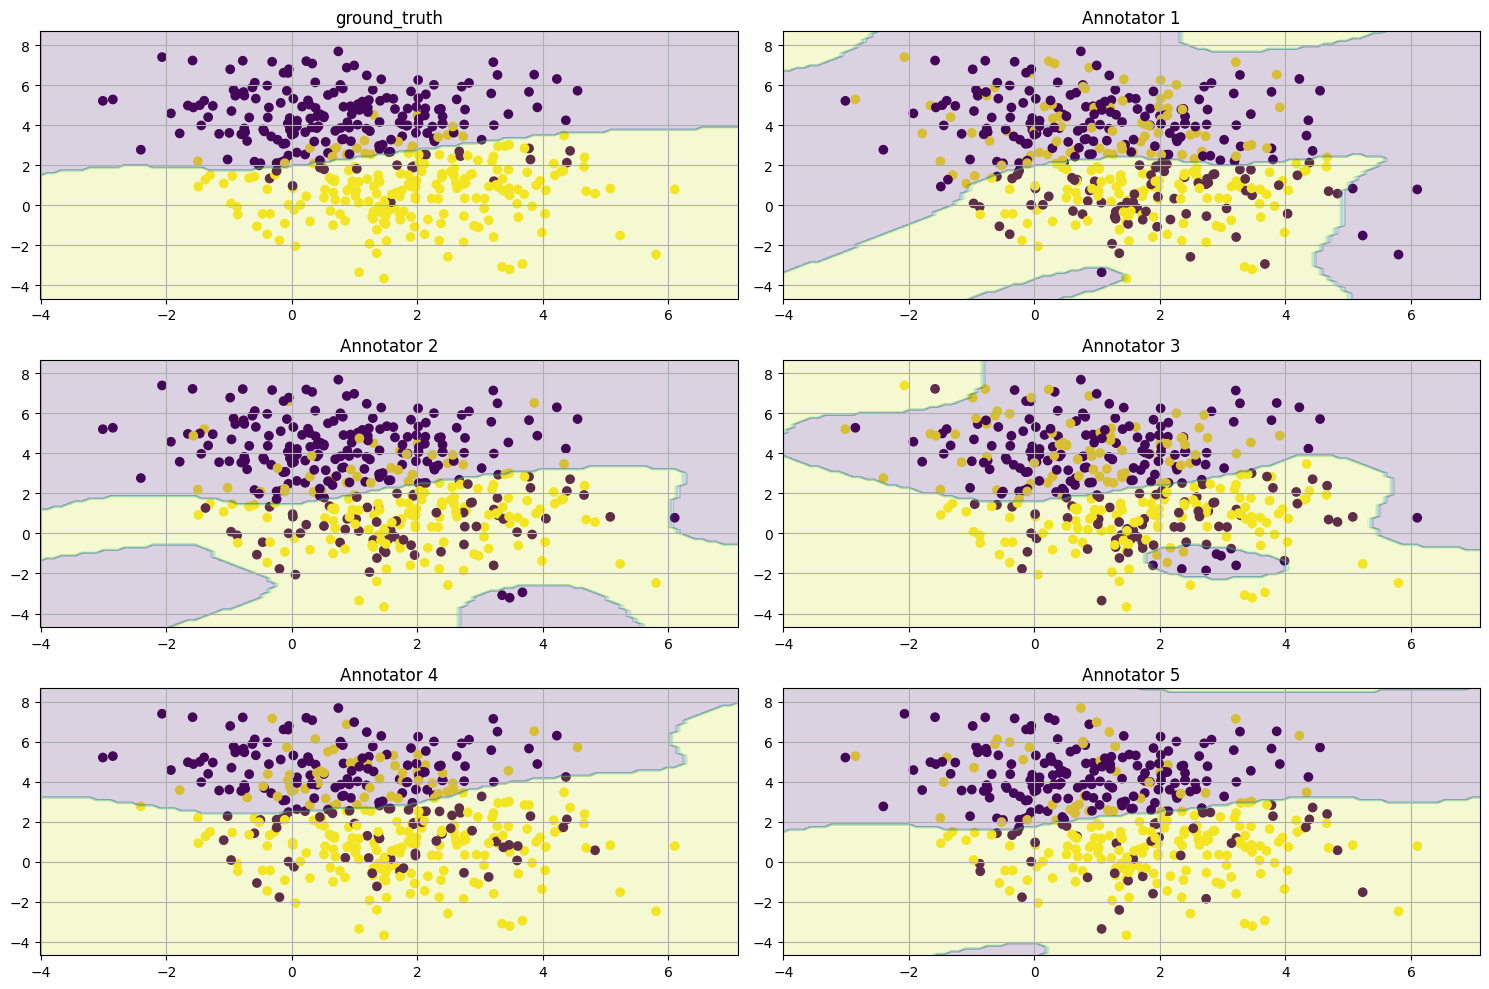

In [4]:
simulation_types = ['o', 'x', 'y'] # e {o (uniform performance values), x (instance dependent performance), y (class dependent performance)}

for simulation_type in simulation_types:
	data_set_name = f'blobs_n_2-simulated-{simulation_type}'
	print(data_set_name)
	# generate dataset
	X, y_true, y = load_data(data_set_name)

	fig, axes = plt.subplots(nrows=3, ncols=2 ,figsize=(15,10))

	for i, ax in enumerate(axes.flatten()):
		if i == 0:
			title = 'ground_truth'
			yi = y_true
		else:
			title = f'Annotator {i}'
			yi = y[:,i-1]
		model = PWC(n_classes=2)
		model.fit(X, yi)
		ax.scatter(X[:,0], X[:,1], c=yi)
		ax.grid(True)
		plot_decision_boundary(model, ax, X, '', .2)
		ax.set_title(title, fontsize=12, color='black')
	plt.tight_layout()
	plt.show()

In [5]:
data_set_name = 'blobs_n_2-simulated-o'
seed = 1234
relabel = True
annotator = 0
nbudget=5
#anntator_selection = partial(select_fixed_annotator, annotator=annotator)
annotator_selection = select_annotator_epm
query_strategy = margin_qs
classifier = partial(PWC, metric='rbf')
with warnings.catch_warnings():
	warnings.filterwarnings("ignore", category= RuntimeWarning)
	warnings.filterwarnings("ignore", category= FutureWarning)
	res = run_experiment(data_set_name=data_set_name, seed=seed, classifier=classifier, 
						nbudget=nbudget, query_strategy=query_strategy, annnotator_selection=annotator_selection, 
						verbose=True, relabel=relabel, n_iterations=30
						)


Iteration: 0. Accuracy: 0.569. MCE: 0.0. ECE: 0.0
Annotations per instance: 1.0. Max annotations: 1
20
Iteration: 1. Accuracy: 0.894. MCE: 0.128. ECE: 0.069
Annotations per instance: 1.0. Max annotations: 1
30
Iteration: 2. Accuracy: 0.844. MCE: 0.048. ECE: 0.019
Annotations per instance: 1.0. Max annotations: 1
40
Iteration: 3. Accuracy: 0.756. MCE: 0.325. ECE: 0.244
Annotations per instance: 1.0. Max annotations: 1
50
Iteration: 4. Accuracy: 0.894. MCE: 0.173. ECE: 0.106
Annotations per instance: 1.02. Max annotations: 2
60
Iteration: 5. Accuracy: 0.931. MCE: 0.083. ECE: 0.044
Annotations per instance: 1.08. Max annotations: 2
70
Iteration: 6. Accuracy: 0.944. MCE: 0.071. ECE: 0.037
Annotations per instance: 1.1. Max annotations: 3
80
Iteration: 7. Accuracy: 0.944. MCE: 0.091. ECE: 0.05
Annotations per instance: 1.18. Max annotations: 3
90
Iteration: 8. Accuracy: 0.894. MCE: 0.128. ECE: 0.069
Annotations per instance: 1.25. Max annotations: 3
100
Iteration: 9. Accuracy: 0.925. MCE: 0

In [6]:
np.where(np.isnan(res['y_DL'][10][np.arange(5)])[2])

(array([0, 1, 3, 4]),)

In [7]:
res['y_DL'][10][np.arange(5)][2]

array([nan, nan,  1., nan, nan])

In [8]:
res['y_DL'][0].shape

(240, 5)

In [9]:
def plot_timestep(timestep):
    # Clear the current plot
    fig, ax = plt.subplots(figsize=(8, 6))

    # Fetch timestep-specific values
    X = res['X_train']
    y_DL = res['y_DL'][timestep]
    model = PWC(n_classes=y_DL.shape[1])
    model.fit(X, y_DL)
    annotations = res['n_annotations'][timestep]
    #cmap = cm.viridis
    colors = ['purple', 'blue', 'green', 'yellow', 'orange', 'red']
    cmap = ListedColormap(colors)

    # Scatter plot
    sc = ax.scatter(X[:, 0], X[:, 1], c=annotations, cmap=cmap, s=50, edgecolor='k', vmin=0, vmax=len(colors) -1)
    # Legend setup
    num_classes = 6
    legend_labels = [i for i in range(num_classes)]
    #colors = [cmap(i / (num_classes - 1)) for i in range(num_classes)]
    handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[i], markersize=10,
                      label=legend_labels[i]) for i in range(num_classes)]

    ax.legend(handles=handles, title='Annotations', loc='upper right')
    ax.grid(True)


    # Plot decision boundary
    plot_decision_boundary(model, ax, X, '', .1)

    ax.set_title(f"Annotations at Timestep {timestep}")

    plt.tight_layout()
    plt.show()

In [10]:
timesteps = len(res['y_DL']) - 1
interact(plot_timestep, timestep=IntSlider(min=0, max=timesteps, step=1, value=0))

interactive(children=(IntSlider(value=0, description='timestep', max=30), Output()), _dom_classes=('widget-int…

<function __main__.plot_timestep(timestep)>

In [11]:
ufcvho4f

NameError: name 'ufcvho4f' is not defined

In [23]:
[np.sum(res['n_annotations'][i]) for i in range(len(res['n_annotations']))]

[np.int64(20),
 np.int64(30),
 np.int64(37),
 np.int64(47),
 np.int64(55),
 np.int64(58),
 np.int64(67),
 np.int64(69),
 np.int64(76),
 np.int64(78),
 np.int64(79),
 np.int64(79),
 np.int64(79),
 np.int64(79),
 np.int64(79),
 np.int64(79),
 np.int64(79),
 np.int64(79),
 np.int64(79),
 np.int64(79),
 np.int64(79),
 np.int64(79),
 np.int64(79),
 np.int64(79),
 np.int64(79),
 np.int64(79),
 np.int64(79),
 np.int64(79),
 np.int64(79),
 np.int64(79),
 np.int64(79),
 np.int64(79),
 np.int64(79),
 np.int64(79),
 np.int64(79),
 np.int64(79),
 np.int64(79),
 np.int64(79),
 np.int64(79),
 np.int64(79),
 np.int64(79),
 np.int64(79),
 np.int64(79),
 np.int64(79),
 np.int64(79),
 np.int64(79),
 np.int64(79),
 np.int64(79),
 np.int64(79),
 np.int64(79),
 np.int64(79),
 np.int64(79),
 np.int64(79),
 np.int64(79),
 np.int64(79),
 np.int64(79),
 np.int64(79),
 np.int64(79),
 np.int64(79),
 np.int64(79),
 np.int64(79),
 np.int64(79),
 np.int64(79),
 np.int64(79),
 np.int64(79),
 np.int64(79),
 np.int64(